# PENG Model for Penguin Species Identification
This product applies machine learning methodologies to accurately predict the species of a penguin given its taxonomy and location. A machine learning model is trained on historical data using the KNN algorithm and assessed for accuracy and processing speed. The model is then applied to predict the species of penguin based upon user input.

# Imports

In [1]:
#@title
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from timeit import default_timer as timer
from datetime import timedelta
%pip install -q ipywidgets
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

percent = '{:.2%}'
rate = '{0:.0f}'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


# Data Loading
A data frame is created by loading in the data from the .csv file. The data frame is then previewed to confirm the data was loaded successfully.

In [2]:
#@title
# create dataframe from csv
url = 'https://raw.githubusercontent.com/Dpay123/Penguin-Species-Identification/main/penguins.csv'
df = pd.read_csv(url)
# preview data
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


# Data Pre-Processing
In this step, the data is prepared for the machine learning model. This includes determining which data gets included/excluded, and/or transformed if needed.

### Cleaning
As seen in the preview of the data, there are null/NaN values which will cause trouble in our machine learning model. Therefore, these records are excluded from the dataset.

In [3]:
#@title
df_cleaned = df.dropna()

### Encoding
Machine learning models work best with numerical data as opposed categorical data. Hence, we will be encoding all of our categorical data, in essence converting a category to a numerical value for more accurate results with the model. Each unique choice/category is encoded with its own value.

We will encode the 3 categorical attributes of the dataset: Island, Sex, and Species, as seen in the preview below.

In [4]:
#@title
# encode categorical columns into individual number columns
df_encoded = pd.get_dummies(df_cleaned, columns = ['island', 'sex'])
# encode species column to numerical column
speciesMap = {'Adelie':0, 'Chinstrap':1, 'Gentoo':2}
df_encoded['species'].replace(speciesMap, inplace=True)
# preview the data
df_encoded.head()  

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,0,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,0,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,0,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,0,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,0,39.3,20.6,190.0,3650.0,0,0,1,0,1


# Data Exploration


### Basic Information
Seen below is a brief overview of the layout of the data, including the data types, counts, and any null values.

In [5]:
#@title
df_cleaned.info()  # get an overview of the layout of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Statistics
We can get a description of the data using basic statistics, which gives us an idea of the range of values of the data. The count also lets us confirm that there are no values missing after cleaning the data. 

In [6]:
#@title
df_cleaned.describe(include="all")  # get a summary of the dataframe

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,333,333,333.000000,333.000000,333.000000,333.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,male
freq,146,163,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.992793,17.164865,200.966967,4207.057057,NaN
std,NaN,NaN,5.468668,1.969235,14.015765,805.215802,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.500000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.500000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.600000,18.700000,213.000000,4775.000000,NaN


### Correlations
This shows correlations between numerical fields in the data. As seen below our data is moderately correlated, which is to be expected, as the numerical data consists of anatomical measurements which are commonly used to distinguish between species of penguins. Based upon this observation, we decide to include these fields in our machine learning model.

In [7]:
#@title
corr = df_encoded.corr()
corr

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
species,1.000000,0.730548,-0.740346,0.850737,0.750434,0.596528,-0.315364,-0.419318,-0.010964,0.010964
bill_length_mm,0.730548,1.000000,-0.228626,0.653096,0.589451,0.225174,0.032118,-0.367821,-0.344078,0.344078
bill_depth_mm,-0.740346,-0.228626,1.000000,-0.577792,-0.472016,-0.626230,0.457326,0.265173,-0.372673,0.372673
flipper_length_mm,0.850737,0.653096,-0.577792,1.000000,0.872979,0.601126,-0.425459,-0.273304,-0.255169,0.255169
body_mass_g,0.750434,0.589451,-0.472016,0.872979,1.000000,0.623702,-0.464666,-0.251369,-0.424987,0.424987
island_Biscoe,0.596528,0.225174,-0.626230,0.601126,0.623702,1.000000,-0.749398,-0.396949,-0.009201,0.009201
island_Dream,-0.315364,0.032118,0.457326,-0.425459,-0.464666,-0.749398,1.000000,-0.310248,0.000673,-0.000673
island_Torgersen,-0.419318,-0.367821,0.265173,-0.273304,-0.251369,-0.396949,-0.310248,1.000000,0.012278,-0.012278
sex_female,-0.010964,-0.344078,-0.372673,-0.255169,-0.424987,-0.009201,0.000673,0.012278,1.000000,-1.000000
sex_male,0.010964,0.344078,0.372673,0.255169,0.424987,0.009201,-0.000673,-0.012278,-1.000000,1.000000


### Visualizations
We can create charts and graphs that allow us to get a better idea of the distribution of the data and potentially identify any correlations. In addition, visualizing the data will allow us to identify trends in non-numerical (categorical) data such as island and sex as they relate to species identification. We can make some generic assumptions based upon the scatterplot below:
- Island is a fair predictor of species: any penguin found on Torgersen is an Adelie penguin, Gentoo penguins are not found on Dream island, etc.
- Body Mass is a fair predictor of species: any penguin above ~5000g will be a Gentoo penguin, while any penguin below ~4000g will not be a Gentoo penguin

Based upon these observations, we will include these variables in our machine learning model as well.

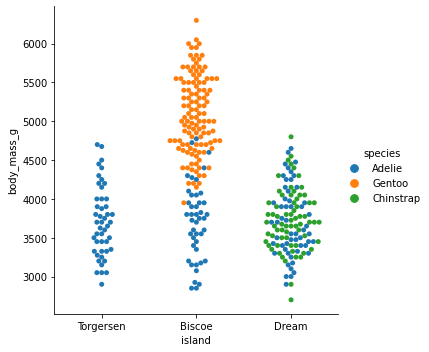

In [8]:
#@title
vis = sns.catplot(data=df_cleaned, x="island", y="body_mass_g", hue="species", kind="swarm")
vis;

### Correlation Visual
As seen in the below correlation heatmap, the data ranges from moderately to strongly correlated. The only noteworth relationships that have little/no correlation are species:sex and sex:island. In plain speak, a penguin's sex and species are not correlated, nor is a penguin's sex correlated to its island. However, because these data points have moderate correlations with other data types, we will not exclude them. 

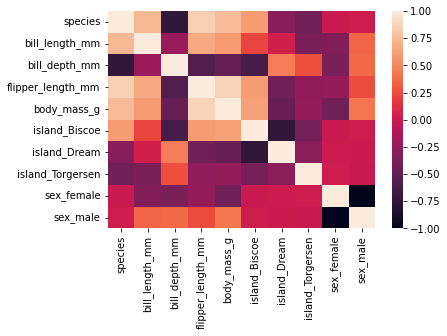

In [9]:
#@title
sns.heatmap(corr);

### Exclusion
As previously determined, we will be including all of the data in our data, so we do not have to process the dataframe to remove anything further. The only data that was excluded was the records with NaN/None/Null type data which were removed from the dataset during the Data Cleaning phase.

### Splitting
The data is split into two distinct datasets; one for training the machine learning model, and one for testing the model.

In [10]:
#@title
# isolate the dependant variabls from the independant variables
X = df_encoded.drop(columns = ['species'])
y = df_encoded['species']
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

# Modeling 
In this phase, the model will be trained using the training dataset and then evaluated for performance using the testing dataset

### Training
We utilize the KNN algorithm (K-Nearest Neighbor) to train the model on the training dataset.

In [11]:
#@title
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train);

### Evaluation
The accuracy of the trained model is evaluated by applying it to the test dataset.
The speed of the model is evaluated by dividing the # of records tested by the processing time and is measured in records/hour.

In [12]:
#@title
# start a timer to measure processing time
start = timer()
# apply model to test data
predict = KNN.predict(X_test)
# measure accuracy of result
result = (accuracy_score(y_test, predict))
# end timer
end = timer()

# get confusion matrix
cf_matrix = confusion_matrix(y_test,predict)

# convert time in seconds to hours
hours = (end-start) / 3600
records = len(X_test.index)
speed = records / hours

print("Accuracy of model: " + percent.format(result))
print("Speed of the model: " + rate.format(speed) + " records/hour")

Accuracy of model: 82.09%
Speed of the model: 13078063 records/hour


**Based on the above metrics, the model can be described as exceeding the objective of the model, as it performs with >50% accuracy and >100 records/hour.**

### Visualize Prediction
The below heatmap highlights the performance of the predictive model. The axis labels of 0, 1, and 2 correspond to species Adelie, Chinstrap, and Gentoo respectively.

As seen from the heatmap, the model correctly predicts Adelie and Gentoo penguins the majority of the time but has more trouble accurately predicting Chinstrap penguins.

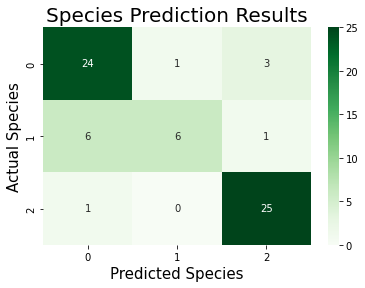

In [13]:
#@title
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')
plt.title('Species Prediction Results', fontsize = 20)
plt.xlabel('Predicted Species', fontsize = 15)
plt.ylabel('Actual Species', fontsize = 15);


# PENGUIN SPECIES PREDICTION
Using our trained machine model, we can predict the species of a penguin given a distinct user input. 
#### Adjust the information below to make a prediction of species. The prediction is adjusted in real time as the data is adjusted!


In [14]:
#@title
# predict the species using the MLM
def predict_species(island, bill_length, bill_depth, flipper_length, body_mass, sex):
    is_biscoe = 0
    is_dream = 0
    is_torg = 0
    is_male = 0
    is_female = 0;
    
    # parse island selection
    if (island == "Biscoe"):
        is_biscoe = 1
    elif (island == "Dream"):
        is_dream = 1
    else:
        is_torg = 1
        
    # parse sex selection
    if (sex == "Male"):
        is_male = 1
    else:
        is_female = 1
        
    # model_input = [bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g, island_Biscoe, island_Dream, island_Torgersen, sex_female, sex_male]
    penguin = np.array([[bill_length, bill_depth, flipper_length, body_mass, is_biscoe, is_dream, is_torg, is_female, is_male]])
    # predict using model - returns {0, 1, or 2}
    prediction = KNN.predict(penguin)
    speciesDict = {0:'Adelie', 1:'Chinstrap', 2:'Gentoo'}
    species = speciesDict[prediction[0]]
    
    # print output
    print("Penguin Species: " + species)
    return

In [15]:
#@title
# this creates the GUI
# It parses user input gathered from widgets and gives input to the model
# It then outputs the prediction from the model in real time
widgets.interact(
                predict_species,
    
                island = widgets.Dropdown(description="Island",options=["Biscoe", "Dream", "Torgersen"]),
                bill_length = widgets.FloatSlider(
                    min=df_cleaned["bill_length_mm"].min(),
                    max=df_cleaned["bill_length_mm"].max(),
                    step=0.01,
                    value=df_cleaned["bill_length_mm"].mean(),
                    description="Bill Length (mm)"
                ),
                bill_depth = widgets.FloatSlider(
                    min=df_cleaned["bill_depth_mm"].min(),
                    max=df_cleaned["bill_depth_mm"].max(),
                    step=0.01,
                    value=df_cleaned["bill_depth_mm"].mean(),
                    description="Bill Depth (mm)"
                ),
                flipper_length = widgets.FloatSlider(
                    min=df_cleaned["flipper_length_mm"].min(),
                    max=df_cleaned["flipper_length_mm"].max(),
                    step=0.01,
                    value=df_cleaned["flipper_length_mm"].mean(),
                    description="Flipper Length (mm)"
                ),
                body_mass = widgets.IntSlider(
                    min=df_cleaned["body_mass_g"].min(),
                    max=df_cleaned["body_mass_g"].max(),
                    value=df_cleaned["body_mass_g"].mean(),
                    description="Body Mass (g)"
                ),
                sex = widgets.Dropdown(description="Sex",options=["Female", "Male"])
            );

interactive(children=(Dropdown(description='Island', options=('Biscoe', 'Dream', 'Torgersen'), value='Biscoe')…